In [1]:
import os # File system operations
import re # Regular expressions
import pandas as pd # Tabular data
import numpy as np # Numerical data
pd.set_option('display.max_colwidth', None) # Show full file paths

from tensorflow import keras # ML

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt # Plotting
from tqdm.auto import tqdm # Progress bars

BASE_DIR = Path("EmbryoLabeling/Labelers/One")
folders = os.listdir(BASE_DIR)
folders = [f for f in folders if not re.match(r"M\d", f)]
df = pd.DataFrame()
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"{BASE_DIR}/{folder}/*.jpg"), columns=["filename"])
    files_in_folder["class"] = folder
    df = df.append(files_in_folder)
df["class"].value_counts()

Morula               82
Empty                75
Compacting 8 cell    38
2 Cell               36
Blastocyst           35
4 Cell               31
2pn                  19
Early blast           8
Cavitating morula     7
7 Cell                6
8 Cell                5
Syngamy               5
10 plus Cell          4
3 Cell                4
5 Cell                4
9 Cell                3
6 Cell                1
Name: class, dtype: int64

<AxesSubplot:>

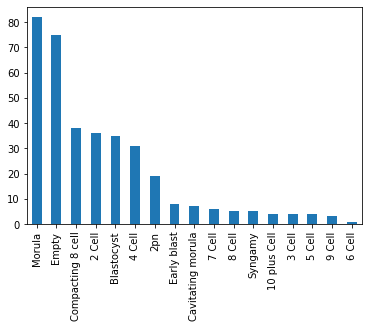

In [2]:
df["class"].value_counts().plot.bar()

In [3]:
# The training dataset is still quite small. To start simple, let's train a binary model, that predicts empty or non-empty
df["class"][df["class"] != "Empty"] = "Non-empty"
train_rows = []
validation_rows = []
for c in df["class"].unique():
    df_for_class = df[df["class"] == c].copy()
    validation_sample = df_for_class.sample(int(len(df_for_class) * .1))
    validation_rows.append(validation_sample)
    #train_sample = df_for_class.drop(validation_sample.index).sample(30)
    train_sample = df_for_class.drop(validation_sample.index)
    train_rows.append(train_sample)
train_df = pd.concat(train_rows)
validation_df = pd.concat(validation_rows)
display(df)
display(train_df["class"].value_counts())
validation_df = validation_df.sample(frac=1)
display(validation_df["class"].value_counts())

,filename,class
0,EmbryoLabeling/Labelers/One/7 Cell/M776_S0087_W2_F0_3205.jpg,Non-empty
1,EmbryoLabeling/Labelers/One/7 Cell/M776_S0087_W2_F0_3185.jpg,Non-empty
2,EmbryoLabeling/Labelers/One/7 Cell/M776_S0087_W2_F0_3245.jpg,Non-empty
3,EmbryoLabeling/Labelers/One/7 Cell/M776_S0087_W2_F0_3145.jpg,Non-empty
4,EmbryoLabeling/Labelers/One/7 Cell/M776_S0087_W2_F0_3225.jpg,Non-empty
...,...,...
70,EmbryoLabeling/Labelers/One/Empty/M776_S0087_W2_F0_7990.jpg,Empty
71,EmbryoLabeling/Labelers/One/Empty/M776_S0087_W2_F0_8190.jpg,Empty
72,EmbryoLabeling/Labelers/One/Empty/M776_S0087_W2_F0_7690.jpg,Empty
73,EmbryoLabeling/Labelers/One/Empty/M776_S0087_W2_F0_8240.jpg,Empty


Non-empty    161
Empty         68
Name: class, dtype: int64

Non-empty    28
Empty         7
Name: class, dtype: int64

In [4]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
training = datagen.flow_from_dataframe(train_df, target_size=(299, 299), batch_size=24, shuffle=True)
# Don't shuffle validation, otherwise confusion_matrix won't work due to mismatch
validation = datagen.flow_from_dataframe(validation_df, target_size=(299, 299), batch_size=24, shuffle=False)

Found 229 validated image filenames belonging to 2 classes.
Found 35 validated image filenames belonging to 2 classes.


In [5]:
assert training.class_indices == validation.class_indices

In [6]:
code2class = {v:k for k, v in training.class_indices.items()}
code2class

{0: 'Empty', 1: 'Non-empty'}

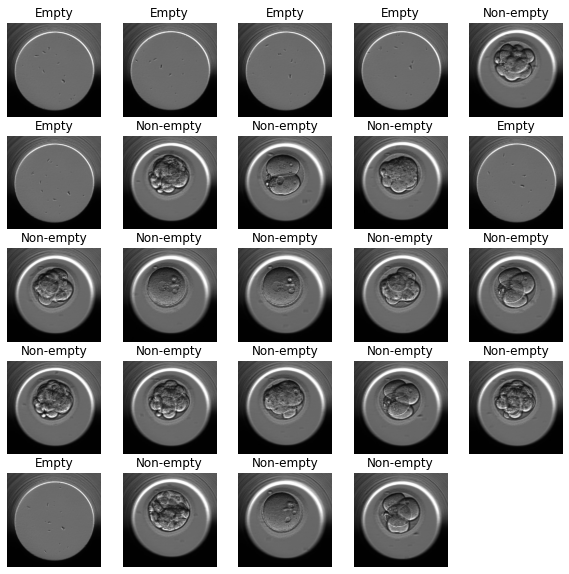

In [7]:
plt.figure(figsize=(10, 10))
images, labels = next(training)
for i in range(24):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

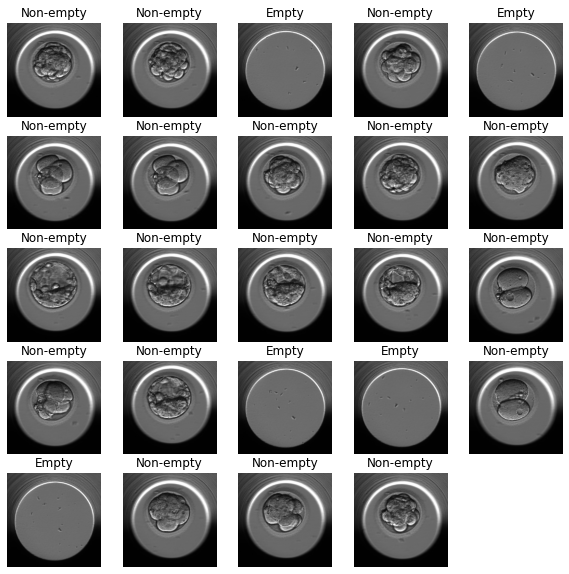

In [8]:
plt.figure(figsize=(10, 10))
images, labels = next(validation)
for i in range(min(24, len(labels))):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

In [9]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(299, 299, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=2, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(len(code2class))(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 20,865,578
Trainable params: 4,098
Non-trainable params: 20,861,480
_____________________________________________

In [10]:
training.reset()
validation.reset()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

history = model.fit(training, epochs=10, validation_data=validation)

Epoch 1/10
10/10 [==============================] - 17s 2s/step - loss: 0.5309 - binary_accuracy: 0.6616 - val_loss: 0.3190 - val_binary_accuracy: 0.8000
Epoch 2/10
10/10 [==============================] - 15s 2s/step - loss: 0.3229 - binary_accuracy: 0.8362 - val_loss: 0.2008 - val_binary_accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - 15s 1s/step - loss: 0.1955 - binary_accuracy: 0.9978 - val_loss: 0.1322 - val_binary_accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 15s 2s/step - loss: 0.1304 - binary_accuracy: 1.0000 - val_loss: 0.0903 - val_binary_accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 15s 2s/step - loss: 0.0921 - binary_accuracy: 1.0000 - val_loss: 0.0644 - val_binary_accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 15s 1s/step - loss: 0.0694 - binary_accuracy: 1.0000 - val_loss: 0.0496 - val_binary_accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 15s 2s/step - loss: 0.05

<AxesSubplot:>

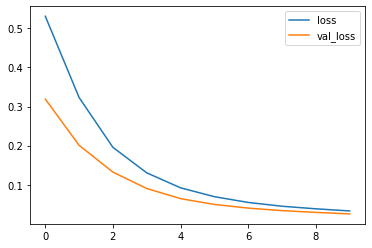

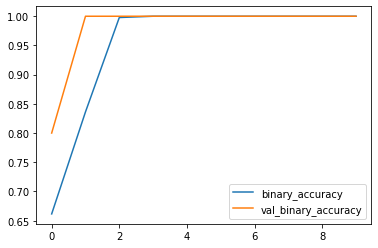

In [11]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['binary_accuracy', 'val_binary_accuracy']].plot()

In [12]:
validation.reset()
print("True:", validation.labels)
print("Predictions: ", model.predict(validation).argmax(axis=1))

True: [1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]
Predictions:  [1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1]


In [13]:
validation.reset()
y_pred = model.predict(validation).argmax(axis=1)
print(confusion_matrix(validation.labels, y_pred))
print(classification_report(validation.labels, y_pred))

[[ 7  0]
 [ 0 28]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        28

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35



In [14]:
model.save("models/empty_or_not.h5")